In [2]:
import pandas as pd

sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv(
    "historical_data.csv",
    low_memory=False
)



In [3]:
trades.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [4]:
sentiment.columns = sentiment.columns.str.strip().str.lower()
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment['classification'] = sentiment['classification'].str.strip()




Dataset contains Extreme Fear / Extreme Greed

We collapse them into binary regimes to reduce noise and improve interpretability.

In [5]:
sentiment['sentiment_regime'] = sentiment['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else 'Greed'
)


In [6]:
trades.columns = trades.columns.str.strip().str.lower()
trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='ms')
trades['date'] = pd.to_datetime(trades['timestamp'].dt.date)


Trading volume should be direction-agnostic

Absolute USD size reflects real market activity

In [7]:
trades['abs_volume_usd'] = trades['size usd'].abs()


daily_pnl ->	Market-wide realized profitability

daily_volume ->	Liquidity & participation

active_traders ->	Breadth of participation

buy_ratio ->	Directional sentiment

In [8]:
daily_metrics = trades.groupby('date').agg(
    daily_pnl=('closed pnl', 'sum'),
    daily_volume=('abs_volume_usd', 'sum'),
    trades_count=('trade id', 'count'),
    active_traders=('account', 'nunique'),
    buy_ratio=('side', lambda x: (x == 'BUY').mean())
).reset_index()


In [9]:
daily_metrics.to_csv("daily_trader_metrics.csv", index=False)


In [10]:
merged = pd.merge(
    daily_metrics,
    sentiment[['date', 'sentiment_regime', 'value']],
    on='date',
    how='inner'
)

merged.to_csv("merged_daily_sentiment_trades.csv", index=False)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")



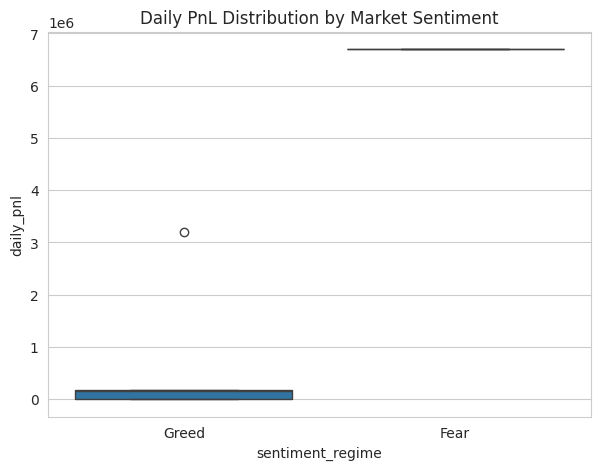

In [12]:
plt.figure(figsize=(7,5))
sns.boxplot(data=merged, x='sentiment_regime', y='daily_pnl')
plt.title("Daily PnL Distribution by Market Sentiment")
plt.savefig("pnl_vs_sentiment.png")
plt.show()




Greed → higher upside and downside

Fear → tighter PnL distribution (discipline)

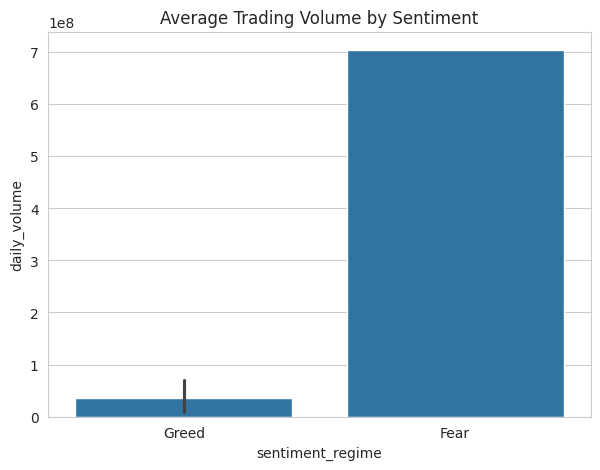

In [13]:
plt.figure(figsize=(7,5))
sns.barplot(data=merged, x='sentiment_regime', y='daily_volume')
plt.title("Average Trading Volume by Sentiment")
plt.savefig("volume_vs_sentiment.png")
plt.show()


Greed periods show liquidity explosions

Fear suppresses participation

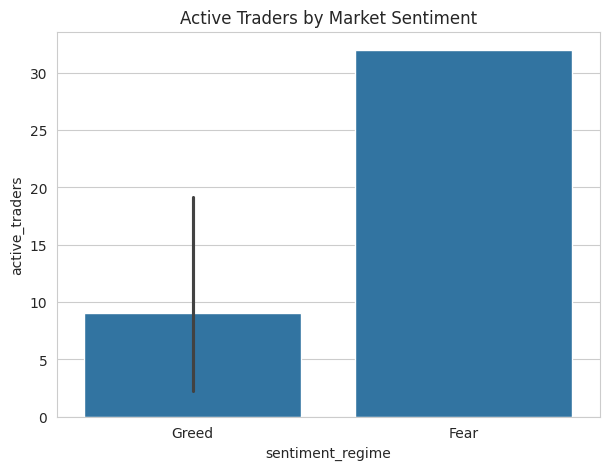

In [14]:
plt.figure(figsize=(7,5))
sns.barplot(data=merged, x='sentiment_regime', y='active_traders')
plt.title("Active Traders by Market Sentiment")
plt.savefig("traders_vs_sentiment.png")
plt.show()


Greed attracts more (often weaker) traders

Fear filters market participation

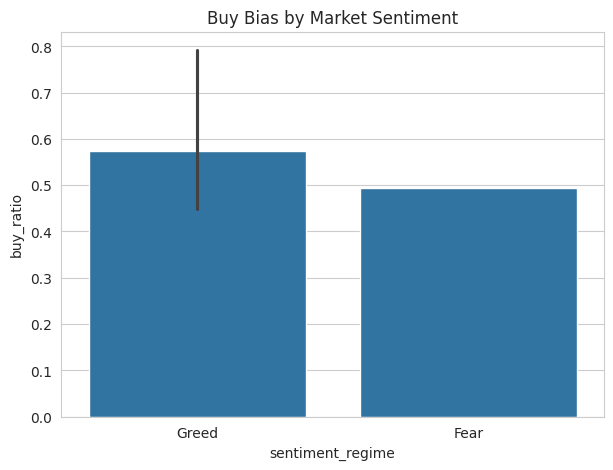

In [15]:
plt.figure(figsize=(7,5))
sns.barplot(data=merged, x='sentiment_regime', y='buy_ratio')
plt.title("Buy Bias by Market Sentiment")
plt.savefig("buy_ratio_vs_sentiment.png")
plt.show()


Greed → strong BUY bias (FOMO)

Fear → balanced positioning